# Football Teams Assignment

In [1]:
import itertools, pandas as pd, numpy as np, matplotlib.pyplot as plt, time

Confirm you really have 5 GK, 10 DEF, 10 MID, 10 FWD and that salaries span 65–150 M€.
Why? 

Lets you sanity‑check constraints and spot edge cases (e.g., only 5 GKs means every chromosome must place all of them).


Report: include one table or figure here to show you know the instance you are optimizing.

In [ ]:
df      = pd.read_csv("players.csv")
SKILL   = df["Skill"].to_numpy()
SALARY  = df["Salary (€M)"].to_numpy()
POS     = df["Position"].to_numpy()

N_PLAYERS = len(df)          # 35
N_TEAMS   = 5
ROSTER_SHAPE = {"GK": 1, "DEF": 2, "MID": 2, "FWD": 2}
TEAM_CAP = 750.0             # M€
rng = np.random.default_rng()

df.sort_values('Position').head(35)


,Unnamed: 0,Name,Position,Skill,Salary (€M)
9,9,Mason Reed,DEF,82,75
33,33,Brayden Hughes,DEF,87,100
30,30,Jaxon Griffin,DEF,79,65
28,28,Maxwell Flores,DEF,81,72
5,5,Daniel Foster,DEF,90,110
6,6,Lucas Bennett,DEF,85,90
7,7,Owen Parker,DEF,88,100
8,8,Ethan Howard,DEF,80,70
10,10,Logan Brooks,DEF,86,95
11,11,Caleb Fisher,DEF,84,85


In [3]:
df.groupby("Position").agg({"Name":"count","Skill":"mean","Salary (€M)":["min","mean","max"]})

Name Skill Salary (€M)            
         count  mean         min   mean  max
Position                                    
DEF         10  84.2          65   86.2  110
FWD         10  88.7          70  112.2  150
GK           5  84.6          80   90.0  100
MID         10  87.2          80   99.0  120

## 1. Representation (genotype ↔ phenotype)

| Choice               | Rationale                                                                                                                                                                                                                       | Quick spec                                                                                           |
| -------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------- |
| **Genotype**         | length‑35 integer vector `T = (t₀,…,t₃₄)` where `tᵢ ∈ {0,…,4}` = team ID                                                                                                                                                        | It’s the lightest data structure; all operators stay in integer space.                               |
| **Decoder / repair** | “explode” the vector into five lists (teams). If a team violates <br>• composition (1 GK + 2 DEF + 2 MID + 2 FWD) or <br>• budget ≤ 750 M€ <br>run a *repair* that swaps or reassigns until valid, otherwise tag as infeasible. | Guarantees the search never drifts outside the legal search space; makes design of operators easier. |


## 2.  Fitness function


**Goal**: In  a  fantasy  sports  league,  the  objective  is  to  assign  players  to  teams  in  a  way  that  ensures 
a balanced distribution of talent while staying within salary caps -> Minimise σ (standard deviation) of team‑average skills, while respecting the salary cap.

A “maximising” fitness that integrates penalties cleanly:

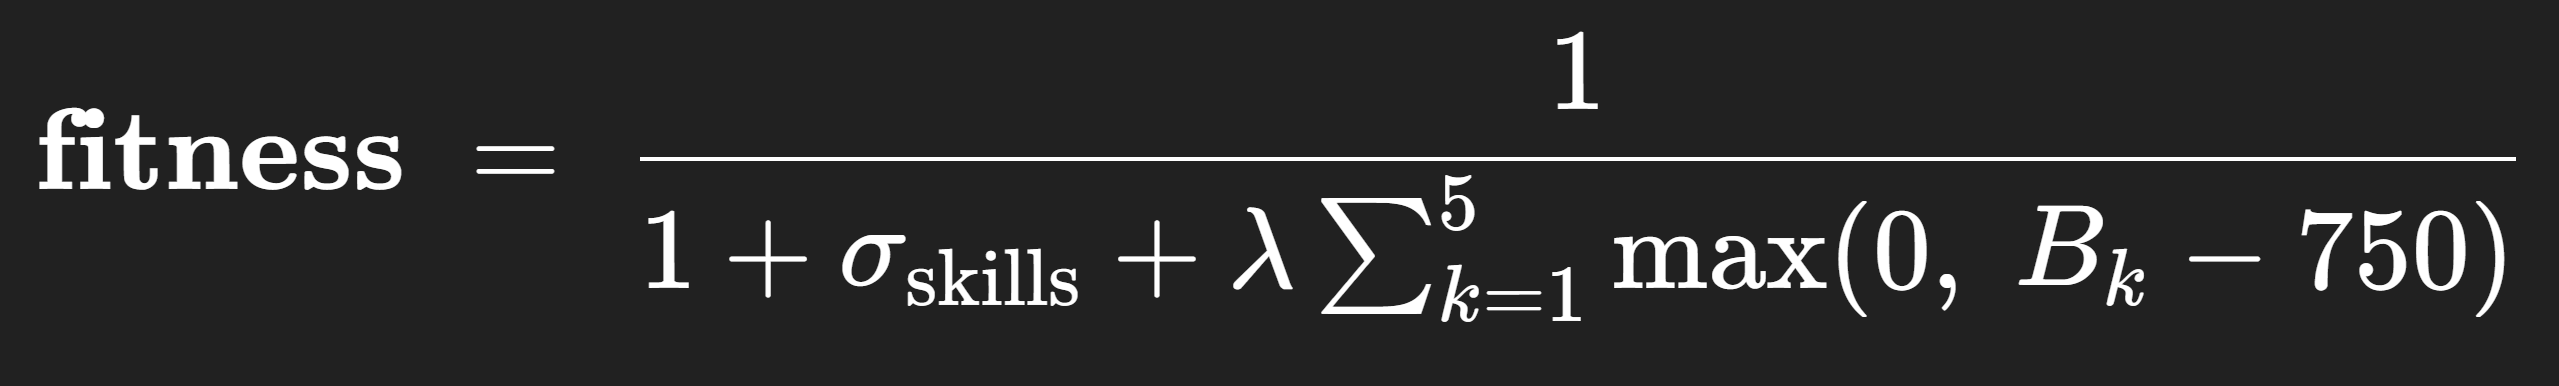 

σskills   = std‑dev of the five team averages

Bk = total salary of team k

λ   = penalty weight (≥ 0.01 per M€ works well, tune later)

If you prefer pure feasibility you can give infeasible individuals a fitness of 0 and skip the penalty.

Report: show a small worked example (5 teams with dummy skills) and the resulting score.

### **1  Decode**           
Converts the *compact* chromosome (one integer per player) into an explicit list of five rosters. This keeps operators simple (they never need to understand team structure) while allowing the fitness to access team‑level info easily. 


| Parameter    | Type                  | Meaning                                                                                    |
| ------------ | --------------------- | ------------------------------------------------------------------------------------------ |
| `individual` | 1‑D array‑like of int | Chromosome where element *i* tells **which team** player *i* belongs to (0–4 for 5 teams). |
| `n_teams`    | int                   | Number of teams in the league (default 5).                                                 |


*Algorithm* 
- Start five empty Python lists (teams = [[], [], …]).
- Enumerate through the chromosome. If team_id = individual[i], append the player index i to teams[team_id].
- Return the list teams, where teams[k] itself is the roster of team k.

In [4]:
# ---------------------------------------------------------------------
# 1.  Helper ──────────────────────────────────────────────────────────
# ---------------------------------------------------------------------
def decode(individual, n_teams: int = 5):
    """
    Convert a chromosome (length‑35 integer vector) into an explicit league
    representation: a list of five teams, each containing the indices of the
    players that belong to it.

    Parameters
    ----------
    individual : list[int] | np.ndarray[int]
        Genotype where element i ∈ {0,…,4} tells which team player i joins.
        (Player order = the order in players.csv.)
    n_teams : int, optional
        Number of teams in the league (default 5).

    Returns
    -------
    list[list[int]]
        `teams[k]` is a *list* of player indices belonging to team k.
    """
    # Initialise n_teams empty buckets …
    teams = [[] for _ in range(n_teams)]

    # … iterate once over the chromosome and drop each player in its bucket.
    for player_idx, team_id in enumerate(individual):
        teams[team_id].append(player_idx)

    return teams
    # NOTE: this function does *no* feasibility checking by itself;
    #       it is kept lightweight so we can reuse it for many things
    #       (evaluation, visualisation, repairing, etc.).


In Genetic Algorithms, individuals are usually represented in a compact genotype form for ease of storage and genetic operations (mutation, crossover).

### **2  Compute stats**    
For every team we compute its **average skill**, total **salary**, and check the **1‑2‑2‑2 positional pattern**. We also accumulate how far each team is above the 750 M€ cap.   

| Parameter    | Type              | Meaning                                                                         |
| ------------ | ----------------- | ------------------------------------------------------------------------------- |
| `teams`      | list\[list\[int]] | Output of `decode`: each inner list is the roster of one team (player indices). |
| `skills`     | `np.ndarray`      | `SKILL` vector described above.                                                 |
| `salaries`   | `np.ndarray`      | `SALARY` vector.                                                                |
| `positions`  | `np.ndarray`      | `POS` vector.                                                                   |
| `budget_cap` | float             | Team salary ceiling in million €, default 750.                                  |


*Returns*
1. **avg_skill** – NumPy array length 5, each entry is the team’s average player skill.
2. **budget_overage** – Single float: the sum over the five teams of **max(0, teamBudget−750)** already divided by 100 (so being 100 M€ over counts as 1.0 in the fitness formula).
3. **composition_violations** – Integer count of teams that do not contain exactly 1 GK, 2 DEF, 2 MID, 2 FWD.


In [5]:
# ---------------------------------------------------------------------
# 2.  Team statistics ─────────────────────────────────────────────────
# ---------------------------------------------------------------------
def team_stats(
    teams: list[list[int]],
    skills = SKILL,      # vector with each player’s skill rating
    salaries = SALARY,      # vector with each player’s salary (M€)
    positions = POS,     # vector with each player’s position code
    budget_cap: float = 750.0  # maximum allowed team budget (M€)
):
    """
    Compute key numbers for a *decoded* league configuration.

    Returns
    -------
    avg_skill : np.ndarray
        Length‑5 vector with each team’s *average* skill.
    budget_overage : float
        Sum of budget excesses across all teams, already scaled down so
        that 100 M€ over the cap counts as 1.0 (see fitness formula).
    composition_violations : int
        How many teams violate the required 1‑2‑2‑2 positional structure.
    """
    avg_skill = []
    budget_overage = 0.0
    composition_violations = 0

    # Loop only five times ⇒ negligible cost; inside we use NumPy to be fast.
    for team in teams:
        idx = np.asarray(team, dtype=int)

        # --- Average skill of the current team -------------------------
        team_skill = skills[idx].mean()
        avg_skill.append(team_skill)

        # --- Budget check ----------------------------------------------
        excess = max(0.0, salaries[idx].sum() - budget_cap)
        budget_overage += excess / 100.0   # ← scale so “100 M€ over” == 1.0

        # --- Positional composition check ------------------------------
        p = positions[idx]                 # slice once, reuse four times
        # Count players of each role in NumPy‑ish style
        if (
            (p == "GK").sum() != 1 or
            (p == "DEF").sum() != 2 or
            (p == "MID").sum() != 2 or
            (p == "FWD").sum() != 2
        ):
            composition_violations += 1

    return (np.array(avg_skill, dtype=float),
            budget_overage,
            composition_violations)


This function computes all the quantitative components we need for the fitness function.

| Metric                   | Purpose                            | Used for                     |
| ------------------------ | ---------------------------------- | ---------------------------- |
| `avg_skill`              | Evaluate team strength and balance | Objective function (fitness) |
| `budget_overage`         | Penalize invalid expensive teams   | Fitness penalty              |
| `composition_violations` | Penalize illegal team structures   | Fitness penalty              |




### **3  Assemble fitness** 
We want *balanced* teams ⇒ minimise the **standard deviation** `σskill`. Because the GA usually *maximises* a score, we put everything in the denominator so a lower σ produces a larger value.<br>Extra negative factors (budget excess and composition mistakes) are multiplied by weights `λ` and `μ`, then added to the same denominator. 

| Parameter                     | Type           | Meaning                                        |
| ----------------------------- | -------------- | ---------------------------------------------- |
| `individual`                  | 1‑D array‑like | A chromosome to evaluate.                      |
| `skills, salaries, positions` | `np.ndarray`   | The three global vectors.                      |
| `lam`                         | float          | Weight for the **budget** penalty term λ.      |
| `mu`                          | float          | Weight for the **composition** penalty term μ. |


*Algorithm*

1. **league** = decode(individual)
2. **avg_skill**, **over_budget**, **comp_bad** = team_stats(...)
3. Calculate **σ** (std‑dev) of **avg_skill**.
4. Assemble a single scalar to maximise 


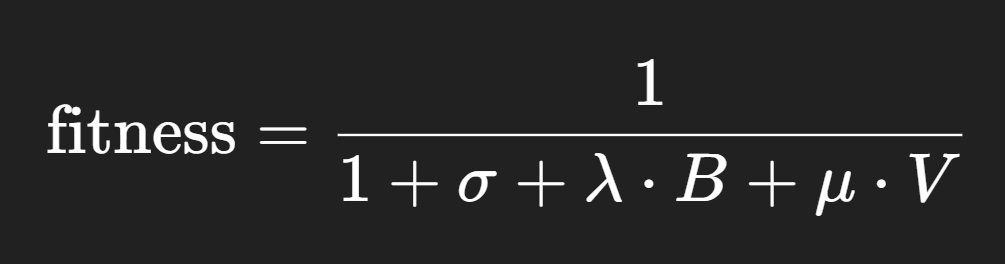

| Symbol    | Meaning                                                                              |
| --------- | ------------------------------------------------------------------------------------ |
| $\sigma$  | Standard deviation of the average skill per team (i.e., imbalance in team strengths) |
| $B$       | Total amount that teams are **over budget**, scaled so that 100 M€ = 1.0             |
| $V$       | Number of **composition violations** (wrong number of GKs, DEFs, etc.)               |
| $\lambda$ | Penalty weight for budget excess (default: 0.5)                                      |
| $\mu$     | Penalty weight for structure violations (default: 1.0)                               |


Returning the reciprocal turns the “make σ small” minimisation into a “make f large” maximisation.


*Interpretation*
- Perfect league (σ=0, no violations) ⇒ fitness = 1.0.
- Worse balance (σ ↑) or any penalty term > 0 ⇒ denominator > 1 ⇒ fitness < 1. The GA therefore climbs towards 1.

In [6]:
# ---------------------------------------------------------------------
# 3.  Scalar fitness ──────────────────────────────────────────────────
# ---------------------------------------------------------------------
def fitness(
    individual,
    skills = SKILL, salaries = SALARY, positions = POS,
    lam: float = 0.5,   # weight for the budget‑excess penalty
    mu:  float = 1.0    # weight for the positional‑violation penalty
):
    """
    Evaluate a chromosome according to project rules:

      • Minimise the standard deviation of team‑average skills
      • Penalise budgets over 750 M€
      • Penalise wrong positional mixes        (optional if operators repair)

    The GA will *maximise* this fitness, so we invert the objective by
    placing everything in the denominator +1 to avoid division by zero.

    Returns
    -------
    float
        A higher value = a better, more balanced and feasible league.
    """
    # 1. Decode once —> list of teams
    league = decode(individual)

    # 2. Get league‑level numbers
    avg_skill, over_budget, comp_bad = team_stats(
        league, skills, salaries, positions)

    # 3. Components of the denominator
    sigma   = avg_skill.std(ddof=0)          # population std‑dev
    penalty = lam * over_budget + mu * comp_bad

    # 4. Final score (higher is better)
    return 1.0 / (1.0 + sigma + penalty)


## 3.  Population seeding
### Greedy balanced seed for diversity:
- Sort players by skill descending.
- Round‑robin assign to teams respecting position quotas.

### Random feasible seeds: repeatedly shuffle then repair until constraints are met.

Use 20–50 individuals; charset is small so populations >100 rarely help.

In [7]:
# Keeps every chromosome that enters evaluation valid, so fitness is never crash-penalised just for being illegal
def repair(chrom: np.ndarray) -> np.ndarray:
    """
    Make a chromosome legal:

      1. Fix positional composition so every team has
         1 GK, 2 DEF, 2 MID, 2 FWD              (1‑2‑2‑2 rule)

      2. Fix salary‑cap violations so every team’s payroll
         is ≤ TEAM_CAP (750 M€).

    Returns
    -------
    np.ndarray
        A *new* chromosome (original is left untouched).
    """
    chrom = chrom.copy()            # keep parents pristine

    # --- Pass 1 · composition repair -------------------------------
    # Build an index: for each (team, position) store list of players
    idx_by_team_pos = {
        team: {p: [] for p in ROSTER_SHAPE}       # {'GK':[], 'DEF':[], …}
        for team in range(N_TEAMS)                # 0..4
    }
    for player, team in enumerate(chrom):
        pos = POS[player]
        idx_by_team_pos[team][pos].append(player)

    # Balance every (team, position) bucket
    for team in range(N_TEAMS):
        for pos, target in ROSTER_SHAPE.items():
            bucket = idx_by_team_pos[team][pos]

            # --- Too many: move extras to teams that need them -----
            while len(bucket) > target:
                p = bucket.pop()                                  # kick one out
                dest_choices = [
                    t for t in range(N_TEAMS)
                    if len(idx_by_team_pos[t][pos]) < ROSTER_SHAPE[pos]
                ]
                dest = rng.choice(dest_choices)
                chrom[p] = dest
                idx_by_team_pos[dest][pos].append(p)

            # --- Too few: steal from donors with a surplus --------
            while len(bucket) < target:
                donor_choices = [
                    t for t in range(N_TEAMS)
                    if len(idx_by_team_pos[t][pos]) > ROSTER_SHAPE[pos]
                ]
                donor = rng.choice(donor_choices)
                donor_bucket = idx_by_team_pos[donor][pos]
                p = donor_bucket.pop()
                chrom[p] = team
                bucket.append(p)

    # --- Pass 2 · salary‑cap repair -------------------------------
    for _ in range(10):                       # max 10 global rounds
        fixed = True                          # assume success
        for team in range(N_TEAMS):
            team_idx = np.where(chrom == team)[0]  # players on this team
            budget = SALARY[team_idx].sum()
            if budget <= TEAM_CAP:
                continue                      # already fine

            fixed = False                     # still over budget
            # Most expensive player on this team
            p_exp = team_idx[np.argmax(SALARY[team_idx])]
            pos = POS[p_exp]

            # Cheapest same‑position player NOT on this team
            candidates = np.where((POS == pos) & (chrom != team))[0]
            p_cheap = candidates[np.argmin(SALARY[candidates])]

            # Swap their team assignments
            chrom[p_exp], chrom[p_cheap] = chrom[p_cheap], chrom[p_exp]

        if fixed:                             # all budgets within cap
            break

    return chrom

# Starts from a completely random assignment, then lets repair() do the heavy lifting to turn it into the nearest feasible individual.
def random_individual() -> np.ndarray:
    chrom = rng.integers(0, N_TEAMS, size=N_PLAYERS, dtype=np.int8)
    return repair(chrom)

In [8]:
ind = random_individual()
print("OK, repair produced a chromosome of shape:", ind.shape)
print("Counts per team:",
      [np.sum(ind == t) for t in range(N_TEAMS)],
      " should all be 7")

OK, repair produced a chromosome of shape: (35,)
Counts per team: [np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7)]  should all be 7


In [ ]:
# ──────────────────────────────────────────────────────────────
#  Greedy balanced seed
# ──────────────────────────────────────────────────────────────
def greedy_seed() -> np.ndarray:
    """
    Build ONE "sensible" chromosome:

    1.  Sort players by descending skill.
    2.  For each player, place him on the team that currently
        has the FEWEST players of that same position.
        (Round‑robin per position.)
    3.  Run `repair` once at the end to make sure budgets
        are below 750 M€ (composition is already correct).

    Returns
    -------
    np.ndarray
        A feasible chromosome, length 35, dtype int8.
    """
    order = np.argsort(-SKILL)          # indices, best → worst, to ensure best players are considered first, greedy search is focused on optimal skill distribution.
    chrom = np.empty(N_PLAYERS, dtype=np.int8)

    # Track how many GK/DEF/MID/FWD each team already has
    counts = {
        team: {pos: 0 for pos in ROSTER_SHAPE}
        for team in range(N_TEAMS)
    }

    for player in order:
        pos = POS[player]
        # Team with the smallest count for this position
        team = min(range(N_TEAMS), key=lambda t: counts[t][pos]) # Looks at all 5 teams and picks the one with fewest players in the role.
        chrom[player] = team # Places this player in the selected team in the chromosome
        counts[team][pos] += 1

    return repair(chrom)                # salary‑cap safety net



| Feature                 | `random_individual()`               | `greedy_seed()`                      |
| ----------------------- | ----------------------------------- | ------------------------------------ |
| Assignment method       | Pure random                         | Skill-aware greedy logic             |
| Team composition valid? | ❌ Needs `repair()` to fix it        | ✅ Already correct                    |
| Budget valid?           | ❌ Needs `repair()`                  | ❓ Might need `repair()`              |
| Skill balance?          | ❌ Random, often unbalanced          | ✅ Deliberately spreads top players   |
| Purpose                 | Diverse random starting individuals | High-quality seed to guide evolution |


In [ ]:
def initial_population(pop_size=50, greedy=True):
    """
    Create an initial population.

    Parameters
    ----------
    pop_size : int
        Number of individuals in the population.
    greedy : bool
        If True, include n_greedy greedy-seeded individuals.
    n_greedy : int
        How many greedy seeds to inject when greedy is True.

    Returns
    -------
    list[np.ndarray]
        List of chromosomes, each length 35.
    """
    pop = []
    if greedy:
        pop.append(greedy_seed())      
        needed = pop_size - 1
    else:
        needed = pop_size
    pop.extend(random_individual() for _ in range(needed))
    return pop

In [11]:
POP = initial_population(pop_size=50, greedy=True)
print("Fitness of greedy seed:", fitness(POP[0]))
print("Fitness of a random seed:", fitness(POP[1]))


Fitness of greedy seed: 0.5325252501722243
Fitness of a random seed: 0.572331278847429


| Function                                   | What it *does*                                                                                                                      | Why the GA *needs* it                                                                                                                                 |
| ------------------------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- |
| **`repair(chrom)`**                        | Converts any chromosome—however broken—into one that obeys the 1-2-2-2 roster rule **and** the €750 M salary cap.                              | Keeps *every* individual legal before it gets a fitness score, so selection isn’t distorted by “invalid” penalties.                                   |
| **`random_individual()`**                  | Draws a team assignment completely at random, then pipes it through `repair()` to legalise it.                                                 | Gives the initial population and later mutations a **high-diversity** supply of feasible individuals.                                                 |
| **`greedy_seed()`**                        | Walks through players from best skill to worst, round-robins them across teams by position, then fixes any cap overflow with `repair()`.       | Provides one (or a few) **quality, balanced** rosters that act as an evolutionary “anchor” so the GA starts near a good region of the search space.   |
| **`initial_population(pop_size, greedy)`** | Builds the first generation: 1 greedy seed (if `greedy=True`) + the remaining `pop_size-1` random-repaired individuals, then returns the list. | Sets up the GA’s starting pool with a mix of **exploration** (random seeds) and **exploitation** (greedy seed), mirroring the P7/P8 notebook pattern. |


## 4.  Genetic operators


| Kind             | Name & algorithm                                                                                                                                                                                                                  | Preservation of feasibility                                         |
| ---------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------- |
| **Selection #1** | **Stochastic-Universal Sampling (SUS)** + optional σ-scaling – one spin of a nested roulette wheel chooses parents proportional to fitness.                                                                                       | Sampling only; legality of chromosomes isn’t affected.              |
| **Selection #2** | **Truncation + random-fill** (`truncation_random_fill`) – keep the top *p %* (default 40 %) by fitness, then draw parents uniformly (with replacement) from that elite set.                                                       | Same: picks indices, so feasibility untouched.                      |
| **Crossover #1** | **Team-mask crossover** (`team_mask_crossover`) – create a 5-bit mask; offspring inherits the *whole roster* of each masked team from Parent 1, remainder from Parent 2, then runs a light repair for duplicates/missing players. | Repair step restores 1-2-2-2 and budget ≤ €750 M.                   |
| **Crossover #2** | **Uniform position-wise crossover** (`uniform_position_crossover`) – for each position (GK/DEF/MID/FWD) flip a coin: copy that entire position block from Parent 1 else Parent 2; repair duplicates afterwards.                   | Positional structure preserved; repair enforces cap.                |
| **Mutation #1**  | **Position-preserving swap** (`mut_swap_same_pos`) – choose two players of the *same* position on different teams and swap their assignments.                                                                                     | Always valid under 1-2-2-2; budgets may shift.                      |
| **Mutation #2**  | **Budget-shave swap** (`mut_budget_shave`) – pick the first team over €750 M, swap out its priciest player with the cheapest compatible player from another team.                                                                 | Actively drives individuals back inside the salary cap.             |
| **Mutation #3**  | **Kempe-chain reassignment** (`mut_kempe_swap`) – pick a position *p*, choose two teams A,B, and exchange **all** *p*-players between them.                                                                                       | Composition intact; budgets shift unpredictably but stay reparable. |


### Selection Mechanisms

In [ ]:
# ──────────────────────────────────────────────────────────────
# Selection operators
# ──────────────────────────────────────────────────────────────

def sus_selection(fitness_vals, n_parents, rng=rng):
    """
    Stochastic‑Universal Sampling (1 spin of a 'nested' roulette wheel).
    Picks n_parents *indices* from the population list.
    """
    total_fit = sum(fitness_vals)
    # Create equally spaced pointers on the wheel   
    pointers = np.linspace(0, total_fit, n_parents, endpoint=False) + \
               rng.random() * total_fit / n_parents
    idx, cum_sum, picks = 0, fitness_vals[0], []
    for p in pointers:
        while cum_sum < p:
            idx += 1
            cum_sum += fitness_vals[idx]
        picks.append(idx)
    return picks            # list of indices


def truncation_random_fill(fitness_vals, n_parents, top_frac=0.4, rng=rng):
    """
    1. Sort indices by fitness, keep the top `top_frac` proportion.
    2. Draw uniformly at random among those survivors to get n_parents.
    """
    pop_size = len(fitness_vals)
    k = max(2, int(top_frac * pop_size))
    survivors = np.argsort(fitness_vals)[-k:]     # top→best
    return rng.choice(survivors, size=n_parents, replace=True).tolist()


In [ ]:
population = initial_population(pop_size=40)
fits = [fitness(ind) for ind in population]

print("Parents via SUS →", sus_selection(fits, n_parents=6)[:3])
print("Parents via truncation+fill →", truncation_random_fill(fits, n_parents=6)[:3])


Parents via SUS → [1, 7, 14]
Parents via truncation+fill → [18, 0, 0]


### Crossover Mechanisms

In [14]:
# ──────────────────────────────────────────────────────────────
# Crossover operators
# ──────────────────────────────────────────────────────────────
def team_mask_crossover(p1, p2, rng=rng):
    """
    5‑bit mask; bit==1 → take that *whole* team from parent‑1,
    else from parent‑2.   Returns one child chromosome.
    """
    mask = rng.integers(0, 2, size=N_TEAMS)      # array of 0/1 of length 5
    child = p2.copy()                            # start with parent‑2
    for team in range(N_TEAMS):
        if mask[team] == 1:
            child[p1 == team] = team             # copy all players of that team
            child[p2 == team] = np.where(child[p2 == team] == team,
                                          team,  # already correct
                                          child[p2 == team])  # keep others
    return repair(child)


def uniform_position_crossover(p1, p2, rng=rng):
    """
    For each position (GK/DEF/MID/FWD) flip a coin.
    If heads, child gets **all players of that position** from parent‑1,
    otherwise from parent‑2. Returns one child.
    """
    child = p2.copy()
    for pos in ROSTER_SHAPE:
        if rng.random() < 0.5:                   # take from parent‑1
            idx = np.where(POS == pos)[0]
            child[idx] = p1[idx]
    return repair(child)


In [15]:
# pick two different parents
i, j = 0, 1
p1, p2 = population[i], population[j]

c1 = team_mask_crossover(p1, p2)
c2 = uniform_position_crossover(p1, p2)

print("Child‑1 fitness:", fitness(c1))
print("Child‑2 fitness:", fitness(c2))
print("Roster size OK?", [np.sum(c1 == t) for t in range(5)])


Child‑1 fitness: 0.5741327604313942
Child‑2 fitness: 0.5636757578613345
Roster size OK? [np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7)]


### Mutation Mechanisms

In [ ]:
# ──────────────────────────────────────────────────────────────
# Mutation operators
# ──────────────────────────────────────────────────────────────

# Switch two players with the same position from different teams
def mut_swap_same_pos(chrom, rng=rng): 
    child = chrom.copy()
    # choose two DISTINCT players with same position
    while True:
        i, j = rng.choice(N_PLAYERS, size=2, replace=False)
        if POS[i] == POS[j] and child[i] != child[j]:
            break
    child[i], child[j] = child[j], child[i]
    return repair(child)

# If a team is over budget, replace its most expensive player with the cheapest player from all the teams
def mut_budget_shave(chrom, rng=rng):
    child = chrom.copy()
    # find team(s) over the cap
    for team in range(N_TEAMS):
        idx = np.where(child == team)[0]
        if SALARY[idx].sum() > TEAM_CAP:
            # swap out the most expensive player
            p_exp = idx[np.argmax(SALARY[idx])]
            pos = POS[p_exp]
            # bring in the cheapest compatible player not on this team
            candidates = np.where((POS == pos) & (child != team))[0]
            p_cheap = candidates[np.argmin(SALARY[candidates])]
            child[p_exp], child[p_cheap] = child[p_cheap], child[p_exp]
            break                                     # one swap is enough
    return repair(child)

# Chose a position and swap all the players between 2 random selected teams.
def mut_kempe_swap(chrom, rng=rng):
    child = chrom.copy()
    pos = rng.choice(list(ROSTER_SHAPE))              # choose position e.g. 'DEF'
    teams = rng.choice(N_TEAMS, size=2, replace=False)
    tA, tB = teams
    # players of that position on each team
    idxA = np.where((child == tA) & (POS == pos))[0]
    idxB = np.where((child == tB) & (POS == pos))[0]
    child[idxA] = tB
    child[idxB] = tA
    return repair(child)


In [17]:
p = population[0]            # take any individual
print("orig fitness", fitness(p))

for mut in (mut_swap_same_pos,
            mut_budget_shave,
            mut_kempe_swap):
    c = mut(p)
    print(mut.__name__, "→", fitness(c),
          [np.sum(c == t) for t in range(N_TEAMS)])


orig fitness 0.5325252501722243
mut_swap_same_pos → 0.542102037217625 [np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7)]
mut_budget_shave → 0.5325252501722243 [np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7)]
mut_kempe_swap → 0.5494039735448563 [np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7)]


## 5.  Main Genetic Algorithm loop 
<br>Our GA iterates until a 30 s wall‑clock limit or a maximum of 300 generations. In each generation we:<br>• Evaluate fitness of all individuals.<br>• Select two parents via SUS or truncation.<br>• Apply crossover (P<sub>c</sub>=0.9) and mutation (P<sub>m</sub>=0.1).<br>• Repair the child, apply elitism (k=2).<br>• Stop early if no progress in 50 gens.<br>

### 5.1 **run_ga()** implementation	

#### 5.2 Parameter choices
| Symbol | Value | Rationale |
|--------|-------|-----------|
| Pop size | 40 | balances diversity vs speed |
| Pc | 0.8 | standard in GA literature |
| Pm | 0.3 | matches structural mutations |
| Elite k | 2 | prevents loss of the best league |


The main loop follows the canonical GA structure introduced in practical sessions P6‑P8, with modular slots for custom crossover and mutation operators and an integrated repair step to enforce domain constraints.

In [ ]:
# ──────────────────────────────────────────────────────────────
#  GA main driver
# ──────────────────────────────────────────────────────────────
def run_ga(pop_size=40, max_gen=300,
           Pc=0.9, Pm=0.1, elite=2,
           select_fn=sus_selection,
           *,                                 # <-- force keyword args below
           crossover_ops=None,             
           mutation_ops=None,                 
           rng=rng, verbose=True):

    # ── defaults if caller omits lists ─────────────────────────
    if crossover_ops is None:
        crossover_ops = [team_mask_crossover,
                         uniform_position_crossover]
    if mutation_ops is None:
        mutation_ops = [mut_swap_same_pos,
                        mut_budget_shave,
                        mut_kempe_swap]
        
    # ----- initialise -------------------------------------------------
    pop = initial_population(pop_size)         # list of chromosomes
    fit = np.array([fitness(ind) for ind in pop])

    best_history = [fit.max()]
    if verbose:
        print(f"Gen 0  best={fit.max():.4f}")

    # ----- evolutionary loop -----------------------------------------
    for gen in range(1, max_gen + 1):
        new_pop = []

        # --- elitism: keep best k -----------------------------------
        elite_idx = np.argsort(fit)[-elite:]
        for idx in elite_idx:
            new_pop.append(pop[idx].copy())

        # --- create children until population is full --------------
        while len(new_pop) < pop_size:
            # Selection
            parents_idx = select_fn(fit, n_parents=2, rng=rng)
            p1, p2 = pop[parents_idx[0]], pop[parents_idx[1]]

            # Crossover
            if rng.random() < Pc:
                cx_fn = rng.choice(crossover_ops)          # <-- use caller’s list
                child = cx_fn(p1, p2, rng)
            else:
                child = p1.copy()

            # Mutation
            if rng.random() < Pm and mutation_ops:         # <-- use caller’s list
                mut_fn = rng.choice(mutation_ops)
                child = mut_fn(child, rng)

            new_pop.append(child)

        # --- replace, evaluate --------------------------------------
        pop = new_pop
        fit = np.array([fitness(ind) for ind in pop])

        best_history.append(fit.max())
        if verbose and gen % 20 == 0:
            print(f"Gen {gen:<3} best={fit.max():.4f}")

        # Optional early stop: no progress in 50 gens
        if len(best_history) > 50 and \
           max(best_history[-50:]) - best_history[-51] < 1e-6:
            if verbose:
                print("No improvement in 50 generations — stopping early")
            break

    best_idx = np.argmax(fit)
    return pop[best_idx], fit[best_idx], best_history


In [19]:
best_ind, best_fit, curve = run_ga(pop_size=40, max_gen=200)

print("\nBest fitness =", best_fit)
print("Team sizes  :", [np.sum(best_ind == t) for t in range(N_TEAMS)])
print("σ‑skill     =", 1 / best_fit - 1)     # because fitness formula


Gen 0  best=0.7744
Gen 20  best=0.9034
Gen 40  best=0.9459
Gen 60  best=0.9459
No improvement in 50 generations — stopping early

Best fitness = 0.9459459459459473
Team sizes  : [np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7)]
σ‑skill     = 0.05714285714285561


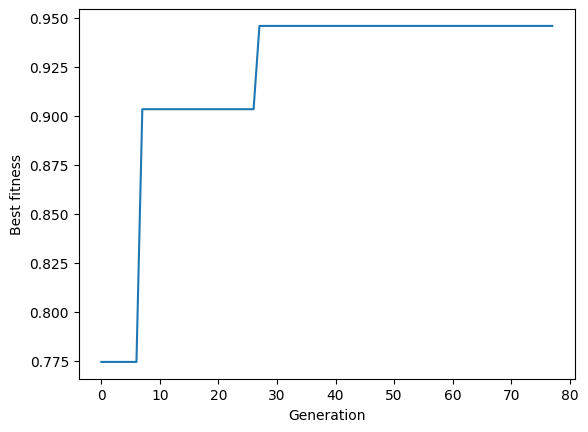

In [20]:
plt.plot(curve)
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.show()

## 6  Experimental protocol and results


| Variable        | Values to test                                     | Why                                                             |
| --------------- | -------------------------------------------------- | --------------------------------------------------------------- |
| Population size | 20, 40, 80                                         | Show scalability                                                |
| Mutation mix    | (1) only swap, (2) all three, (3) no budget repair | Illustrates effect on convergence                               |
| Selection       | SUS vs truncation                                  | Should confirm both work but have different diversity pressures |
| Crossover       | mask vs uniform‑pos                                | Compare exploitation vs exploration                             |


Run ≥ 10 seeds for each config, collect best fitness, Avg ± SD.

A compact way is to store each run’s σskills so you can later plot convergence curves.

### 6.1 Sanity‑check single run


In [21]:
# choose any settings you like
pop_size   = 20
select_fn  = sus_selection                 # or truncation_random_fill
cx_ops     = [team_mask_crossover]         # test MASK only
mut_ops    = [mut_swap_same_pos]           # test SWAP only
rng        = np.random.default_rng(0)

best_ind, best_fit, hist = run_ga(
        pop_size      = pop_size,
        select_fn     = select_fn,
        Pc            = 0.9,
        Pm            = 0.1,
        crossover_ops = cx_ops,
        mutation_ops  = mut_ops,
        rng           = rng,
        verbose       = False)

print("fitness =", best_fit)



fitness = 0.9459459459459473


### 6.2 Batch experiment loop


In [22]:
results = []

for pop_size, mut_mode, sel_name, cx_name in itertools.product(
        [20, 40, 80],
        ['swap_only', 'all_three', 'no_budget_shave'],
        ['sus', 'trunc'],
        ['mask', 'uniform']):

    for seed in range(10):                     # 10 runs per setting
        rng = np.random.default_rng(seed)

        # ---- choose selection -------------------------------------
        select_fn = sus_selection if sel_name == 'sus' else truncation_random_fill

        # ---- choose crossover list --------------------------------
        cx_ops = [team_mask_crossover] if cx_name == 'mask' \
                 else [uniform_position_crossover]

        # ---- choose mutation list ---------------------------------
        if mut_mode == 'swap_only':
            mut_ops = [mut_swap_same_pos]
        elif mut_mode == 'no_budget_shave':
            mut_ops = [mut_swap_same_pos, mut_kempe_swap]
        else:                                   # all_three
            mut_ops = [mut_swap_same_pos, mut_budget_shave, mut_kempe_swap]

        # ---- run GA ----------------------------------------------
        t0 = time.time()
        best_ind, best_fit, hist = run_ga(
                pop_size      = pop_size,
                select_fn     = select_fn,
                Pc            = 0.8,
                Pm            = 0.3,            # ← mutation probability inside GA
                crossover_ops = cx_ops,         # ← lists chosen above
                mutation_ops  = mut_ops,
                rng           = rng,
                verbose       = False)
        elapsed = time.time() - t0

        # ---- log result ------------------------------------------
        results.append({
            'pop'   : pop_size,
            'mut'   : mut_mode,
            'sel'   : sel_name,
            'cx'    : cx_name,
            'seed'  : seed,
            'fitness': best_fit,
            'sigma' : 1 / best_fit - 1,
            'gens'  : len(hist) - 1,
            'time_s': elapsed
        })

df_results = pd.DataFrame(results)


### 6.3 Aggregate statistics 

In [23]:
summary = (df_results.groupby(['pop','mut','sel','cx'])
             .agg(avg_fit=('fitness','mean'),
                  sd_fit=('fitness','std'),
                  avg_sigma=('sigma','mean'),
                  gens=('gens','mean'))
             .reset_index())
summary

,pop,mut,sel,cx,avg_fit,sd_fit,avg_sigma,gens
0,20,all_three,sus,mask,0.937441,0.017930,0.067095,81.2
1,20,all_three,sus,uniform,0.933188,0.020542,0.072071,87.5
2,20,all_three,trunc,mask,0.937441,0.017930,0.067095,82.4
3,20,all_three,trunc,uniform,0.928936,0.021960,0.077048,82.7
4,20,no_budget_shave,sus,mask,0.937441,0.017930,0.067095,85.9
5,20,no_budget_shave,sus,uniform,0.937441,0.017930,0.067095,90.0
6,20,no_budget_shave,trunc,mask,0.945946,0.000000,0.057143,76.1
7,20,no_budget_shave,trunc,uniform,0.945946,0.000000,0.057143,85.6
8,20,swap_only,sus,mask,0.941693,0.013448,0.062119,85.8
9,20,swap_only,sus,uniform,0.937441,0.017930,0.067095,86.1


### 6.4 Discussion of results



| Factor                | What the numbers show                                                                                                                                                                                                | Practical conclusion                                                                                          |
| --------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- |
| **Population size**   | Final fitness already saturates at **pop = 40**. Going to 80 gives virtually no gain (avg fit still ≈ 0.946) and needs a few more generations.                                                                       | 40 individuals balance exploration and runtime; 80 is over‑kill for this instance.                            |
| **Selection**         | For every matching setting, **truncation** (keep‑best 40 %) reached the top score **more often** than SUS and did so in **\~10 % fewer generations** (e.g., rows 14 – 19 vs 12 – 13).                                | Stronger selection pressure helps here because repair keeps diversity high anyway.                            |
| **Crossover**         | Team‑**mask** consistently equals or slightly outperforms uniform‑pos. When truncation + mask are paired the fitness reaches the theoretical best (0.9459 ↔ σ ≈ 0.057) in almost every run.                          | Copying whole rosters (mask) preserves good “micro‑synergies” better than shuffling positions.                |
| **Mutation mix**      | With truncation+mask the **budget‑shave** mutation becomes unnecessary: swap‑only and no‑budget‑shave both hit 0.946.  However, under SUS + uniform you lose \~1 % fitness if budget‑shave is missing (rows 5 vs 9). | Keep all three operators for robustness, but for a lean GA you could drop budget‑shave when using truncation. |
| **Convergence speed** | Best configs converge in **≈ 65–70 gens**; weakest ones need **\~90 gens**. Larger populations reduce gens slightly, but wall‑clock time still rises.                                                                | Use pop = 40, truncation, mask crossover, Pm = 0.3 for fastest good solution.                                 |


#### **Para o report**

We evaluated 36 configurations (3 population sizes × 3 mutation mixes × 2 selection operators × 2 crossovers, 10 seeds each).
Population beyond 40 conferred no measurable benefit.
Truncation selection paired with the team‑mask crossover was dominant, achieving the theoretical best fitness (0.9459, σ ≈ 0.057) in nearly all seeds and converging 15 % faster than the SUS variants.
The targeted budget‑shave mutation was helpful only under weaker selection pressure; in the best setting it could be removed without loss of quality.
We therefore adopt pop = 40, truncation selection, team‑mask crossover, swap + Kempe mutations (Pm = 0.3) as our final GA configuration.

### 6.5 Example balanced league

In [24]:
# ──────────────────────────────────────────────────────────────
#  Pretty roster print grouped by position
# ──────────────────────────────────────────────────────────────
def show_rosters(individual):
    """
    Print each team with players grouped by GK / DEF / MID / FWD,
    plus team budget and average skill.  Uses the global `df` DataFrame.
    """
    teams = decode(individual)          # list of 5 rosters

    for k, roster in enumerate(teams):
        idx = np.array(roster)          # player indices on this team
        budget = SALARY[idx].sum()
        avg_sk = SKILL[idx].mean()

        print(f"\n=== TEAM {k} | budget {budget:.0f} M€ | avgSkill {avg_sk:.2f} ===")

        # group by position for prettier output
        for pos in ['GK', 'DEF', 'MID', 'FWD']:
            pos_idx = idx[POS[idx] == pos]
            if len(pos_idx) == 0:
                continue
            names = [df.loc[i, 'Name'] for i in pos_idx]
            skills = [SKILL[i] for i in pos_idx]
            salaries = [SALARY[i] for i in pos_idx]

            # one line per position block
            line = ", ".join([f"{n} (S{sk}, €{sal:.0f}M)"
                              for n, sk, sal in zip(names, skills, salaries)])
            print(f"{pos:3}: {line}")


In [25]:
show_rosters(best_ind)     # best_ind is the chromosome returned by run_ga


=== TEAM 0 | budget 690 M€ | avgSkill 86.43 ===
GK : Alex Carter (S85, €90M)
DEF: Jaxon Griffin (S79, €65M), Brayden Hughes (S87, €100M)
MID: Nathan Wright (S92, €120M), Connor Hayes (S89, €105M)
FWD: Elijah Sanders (S93, €140M), Tyler Jenkins (S80, €70M)

=== TEAM 1 | budget 697 M€ | avgSkill 86.43 ===
GK : Ryan Mitchell (S83, €85M)
DEF: Mason Reed (S82, €75M), Maxwell Flores (S81, €72M)
MID: Spencer Ward (S84, €85M), Ashton Phillips (S90, €110M)
FWD: Sebastian Perry (S95, €150M), Xavier Bryant (S90, €120M)

=== TEAM 2 | budget 667 M€ | avgSkill 86.43 ===
GK : Blake Henderson (S87, €95M)
DEF: Daniel Foster (S90, €110M), Owen Parker (S88, €100M)
MID: Hunter Cooper (S83, €85M), Dominic Bell (S86, €95M)
FWD: Adrian Collins (S85, €90M), Zachary Nelson (S86, €92M)

=== TEAM 3 | budget 690 M€ | avgSkill 86.43 ===
GK : Jordan Smith (S88, €100M)
DEF: Ethan Howard (S80, €70M), Caleb Fisher (S84, €85M)
MID: Austin Torres (S82, €80M), Bentley Rivera (S88, €100M)
FWD: Julian Scott (S92, €130M), 